In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt


# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [10]:
data = pd.read_csv('Dataset/data_for_model.csv')
data = reduce_mem_usage(data)

Memory usage of dataframe is 780232448.00 MB
Memory usage after optimization is: 177994330.00 MB
Decreased by 77.2%


In [11]:
from sklearn.model_selection import KFold

X_train = data.loc[data['sample']=='train', :].drop(['isDefault', 'sample'], axis=1)
X_test = data.loc[data['sample']=='test', :].drop(['isDefault', 'sample'], axis=1)
y_train = data.loc[data['sample']=='train', 'isDefault']

folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [12]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=2000, verbose_eval=1000, early_stopping_rounds=200)

D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[349]	valid_0's auc: 0.731658


未调参前lightgbm单模型在验证集上的AUC：0.7316577918469732


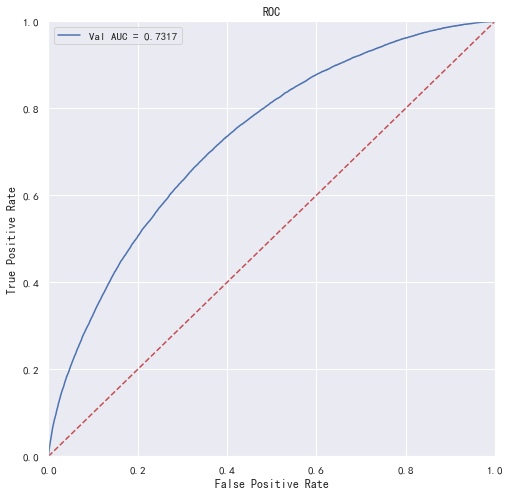

In [22]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))

plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label='Val AUC = %0.4f' % roc_auc)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [23]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
[LightGBM] [Warning] Unknown parameter: silent
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
Trainin

In [25]:
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [ ]:
lgb_params = {'num_leaves': range(10, 80, 5), 'max_depth': range(3,10,2)}
get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""num_leaves为30，max_depth为7，进一步细调num_leaves和max_depth"""
lgb_params = {'num_leaves': range(25, 35, 1), 'max_depth': range(5,9,1)}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""
确定min_data_in_leaf为45，min_child_weight为0.001 ，下面进行bagging_fraction、feature_fraction和bagging_freq的调参
"""
lgb_params = {'bagging_fraction': [i/10 for i in range(5,10,1)], 
              'feature_fraction': [i/10 for i in range(5,10,1)],
              'bagging_freq': range(0,81,10)
             }
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=None, feature_fraction=None, bagging_freq=None, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

"""
确定bagging_fraction为0.4、feature_fraction为0.6、bagging_freq为 ，下面进行reg_lambda、reg_alpha的调参
"""
lgb_params = {'reg_lambda': [0,0.001,0.01,0.03,0.08,0.3,0.5], 'reg_alpha': [0,0.001,0.01,0.03,0.08,0.3,0.5]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=0, reg_lambda=None, reg_alpha=None, param_grid=lgb_params)

"""
确定reg_lambda、reg_alpha都为0，下面进行min_split_gain的调参
"""
lgb_params = {'min_split_gain': [i/10 for i in range(0,11,1)]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=None, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 95372, number of negative: 394821
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6235
[LightGBM] [Info] Number of data points in the train set: 490193, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194560 -> initscore=-1.420647
[LightGBM] [Info] Start training from score -1.420647
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.725102
[2000]	valid_0's auc: 0.728618
[3000]	valid_0's auc: 0.729786
[4000]	valid_0's auc: 0.730394
[5000]	valid_0's auc: 0.730814
[6000]	valid_0's auc: 0.731123
[7000]	valid_0's a

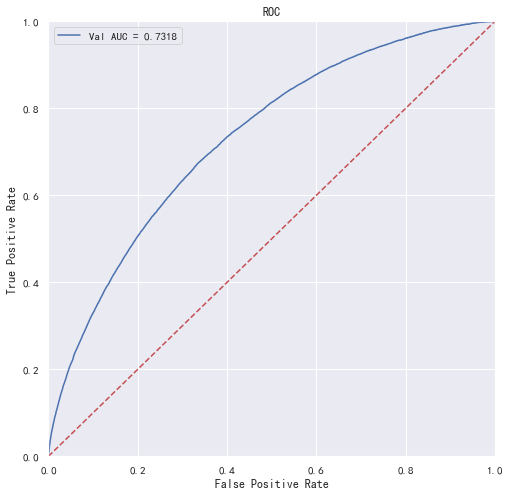

In [31]:
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
}

"""使用训练集数据进行模型训练"""
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=13000, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(X_val)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [32]:
import pickle

pickle.dump(final_model_lgb, open('Dataset/model_lgb_best.pkl', 'wb'))